In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_parquet('data/green_tripdata_2025-01.parquet')

In [4]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [5]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.000000
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.000000
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.000000
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.000000


In [6]:
categorial = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [7]:
df[categorial] = df[categorial].astype(str)

In [14]:
train_dicts = df[categorial + numerical].to_dict(orient='records')

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 138921 stored elements and shape (46307, 449)>

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
y_train

array([14.18333333,  5.88333333,  1.86666667, ..., 21.        ,
        3.        ,  7.        ])

In [28]:
lr = Lasso()
lr.fit(X_train, y_train)

Lasso()

In [29]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_2114/1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2114/1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


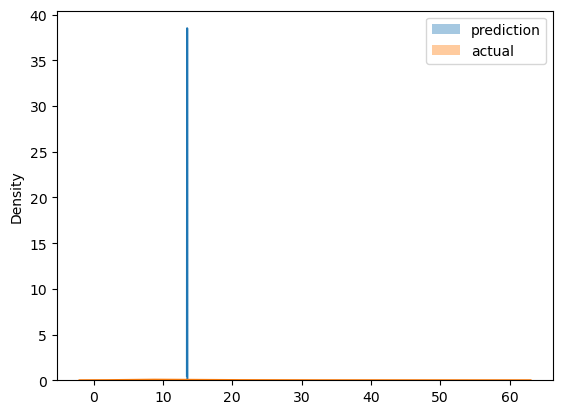

In [30]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [31]:
mean_squared_error(y_train, y_pred)

74.43046062804821